# Analisis Sistem Deteksi Anomali dalam Transaksi
## UTS Data Mining - K3/2025

Notebook ini berisi:
1. Studi Kasus: Deteksi anomali pada transaksi pembelian (Kesalahan Input vs Transaksi Valid Besar)
2. Implementasi Metode:
   - Statistical Methods: IQR, Z-Score, Modified Z-Score
   - Machine Learning: Isolation Forest, Local Outlier Factor (LOF), Ensemble
   - Deep Learning: Autoencoder 
   - Hybrid: Kombinasi metode + rule-based validation
3. Uji coba pada data sintetis dan analisis performa

### Kebutuhan Sistem
- Python 3.7+ 
- Libraries: pandas, numpy, scikit-learn
- Optional: TensorFlow untuk bagian Deep Learning

### Setup
Jalankan sel pertama untuk mengatur path dan memeriksa versi libraries.

In [1]:
# Setup: tambahkan parent folder ke sys.path agar modul src dapat diimport
import sys
from pathlib import Path
sys.path.insert(0, str(Path('..').resolve()))

import pandas as pd
import numpy as np
print('Python:', sys.version.splitlines()[0])
print('pandas:', pd.__version__)
print('numpy:', np.__version__)

Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
pandas: 2.3.3
numpy: 2.3.4


## Generate sample data
Agar notebook independen, kita buat dataset contoh singkat yang mirip dengan generator di `data/generate_sample_data.py`.

In [2]:
# Generate realistic sample transactions
np.random.seed(42)
n = 1000

# Generate customer data
n_customers = 50
customers = pd.DataFrame({
    'Customer_ID': range(n_customers),
    'Customer_Type': np.random.choice(['Regular', 'VIP', 'Corporate'], n_customers, p=[0.7, 0.2, 0.1]),
})

# Generate product data with realistic prices
n_products = 20
product_categories = ['Obat Resep', 'Obat Bebas', 'Alat Kesehatan', 'Suplemen', 'Kosmetik']
products = pd.DataFrame({
    'Product_ID': range(n_products),
    'Category': np.random.choice(product_categories, n_products),
    'Base_Price': np.random.choice([
        np.random.uniform(5_000, 50_000),      # Obat murah
        np.random.uniform(50_000, 200_000),    # Obat sedang
        np.random.uniform(200_000, 1_000_000), # Obat mahal
        np.random.uniform(1_000_000, 5_000_000) # Alat kesehatan
    ], n_products)
})

# Generate transactions
transactions = []
for i in range(n):
    customer_id = np.random.randint(0, n_customers)
    customer_type = customers.loc[customers['Customer_ID'] == customer_id, 'Customer_Type'].values[0]
    
    product_id = np.random.randint(0, n_products)
    base_price = products.loc[products['Product_ID'] == product_id, 'Base_Price'].values[0]
    
    # Quantity depends on customer type
    if customer_type == 'Corporate':
        quantity = np.random.randint(10, 200)
    elif customer_type == 'VIP':
        quantity = np.random.randint(5, 50)
    else:
        quantity = np.random.randint(1, 20)
    
    # Add some price variation
    price_variation = np.random.normal(1.0, 0.1)
    unit_price = base_price * max(0.5, price_variation)
    total_bayar = unit_price * quantity
    
    transactions.append({
        'Transaction_ID': i,
        'Customer_ID': customer_id,
        'Customer_Type': customer_type,
        'Product_ID': product_id,
        'Quantity': quantity,
        'Unit_Price': unit_price,
        'Total_Bayar': total_bayar
    })

df = pd.DataFrame(transactions)

# Inject synthetic errors and legitimate high-value transactions
error_indices = [10, 11, 12, 13, 14]  # kesalahan input
legit_indices = [20, 21, 22]  # transaksi valid besar

# Add ERRORS
for idx in error_indices:
    error_type = np.random.choice(['extra_zero', 'wrong_quantity', 'decimal_error'])
    if error_type == 'extra_zero':
        df.loc[idx, 'Total_Bayar'] *= 100  # Accidentally added extra zeros
    elif error_type == 'wrong_quantity':
        df.loc[idx, 'Quantity'] *= np.random.randint(50, 200)
        df.loc[idx, 'Total_Bayar'] = df.loc[idx, 'Unit_Price'] * df.loc[idx, 'Quantity']
    elif error_type == 'decimal_error':
        df.loc[idx, 'Total_Bayar'] *= 1000  # Decimal point error

# Add LEGITIMATE HIGH-VALUE transactions
for idx in legit_indices:
    # Set as Corporate customer
    df.loc[idx, 'Customer_Type'] = 'Corporate'
    # Use expensive product
    expensive_product = products.nlargest(1, 'Base_Price')
    df.loc[idx, 'Unit_Price'] = expensive_product['Base_Price'].values[0]
    df.loc[idx, 'Quantity'] = np.random.randint(50, 300)
    df.loc[idx, 'Total_Bayar'] = df.loc[idx, 'Unit_Price'] * df.loc[idx, 'Quantity']

df['Total_Bayar'] = df['Total_Bayar'].abs()

# Add ground truth labels
df['Ground_Truth'] = 'Normal'
df.loc[error_indices, 'Ground_Truth'] = 'Error'
df.loc[legit_indices, 'Ground_Truth'] = 'Legitimate High-Value'

print("Sample Data Summary:")
print(f"Total transactions: {len(df)}")
print(f"\nGround Truth distribution:")
print(df['Ground_Truth'].value_counts())
print(f"\nTotal Bayar statistics:")
print(f"  Mean: Rp {df['Total_Bayar'].mean():,.0f}")
print(f"  Median: Rp {df['Total_Bayar'].median():,.0f}")
print(f"  Min: Rp {df['Total_Bayar'].min():,.0f}")
print(f"  Max: Rp {df['Total_Bayar'].max():,.0f}")

df.head()

Sample Data Summary:
Total transactions: 1000

Ground Truth distribution:
Ground_Truth
Normal                   992
Error                      5
Legitimate High-Value      3
Name: count, dtype: int64

Total Bayar statistics:
  Mean: Rp 56,721,063
  Median: Rp 8,104,514
  Min: Rp 36,981
  Max: Rp 14,125,561,483


,Transaction_ID,Customer_ID,Customer_Type,Product_ID,Quantity,Unit_Price,Total_Bayar,Ground_Truth
0,0,7,VIP,11,38,9.651926e+05,3.667732e+07,Normal
1,1,23,Regular,4,3,9.133502e+05,2.740051e+06,Normal
2,2,43,Corporate,7,44,3.664613e+06,1.612430e+08,Normal
3,3,13,Regular,2,1,4.057983e+06,4.057983e+06,Normal
4,4,4,Regular,13,7,6.026159e+04,4.218311e+05,Normal


## Statistical methods (IQR, Z-Score, Modified Z-Score)
Menjalankan deteksi anomali univariat pada kolom `Total_Bayar`.

In [3]:
from src.statistical_methods import detect_anomalies_iqr, detect_anomalies_zscore, detect_anomalies_modified_zscore, compare_statistical_methods

# IQR example
anoms_iqr, stats_iqr = detect_anomalies_iqr(df, 'Total_Bayar')
print('IQR — total anomalies:', stats_iqr['total_anomalies'], f"({stats_iqr['percentage']:.2f}%)")
display(anoms_iqr.head())

# Z-Score example
anoms_z, stats_z = detect_anomalies_zscore(df, 'Total_Bayar')
print('Z-Score — total anomalies:', stats_z['total_anomalies'], f"({stats_z['percentage']:.2f}%)")
display(anoms_z.head())

# Compare summary
comp = compare_statistical_methods(df, 'Total_Bayar')
print('Summary:', comp['summary'])

IQR — total anomalies: 120 (12.00%)


,Transaction_ID,Customer_ID,Customer_Type,Product_ID,Quantity,Unit_Price,Total_Bayar,Ground_Truth,anomaly_type,method
2,2,43,Corporate,7,44,3.664613e+06,1.612430e+08,Normal,above_upper_bound,IQR
12,12,40,Regular,2,1120,4.140914e+06,4.637824e+09,Error,above_upper_bound,IQR
13,13,36,Regular,0,19,3.578084e+06,6.798360e+09,Error,above_upper_bound,IQR
14,14,41,Regular,11,15,9.417041e+05,1.412556e+10,Error,above_upper_bound,IQR
20,20,18,Corporate,1,124,4.088979e+06,5.070334e+08,Legitimate High-Value,above_upper_bound,IQR


Z-Score — total anomalies: 3 (0.30%)


,Transaction_ID,Customer_ID,Customer_Type,Product_ID,Quantity,Unit_Price,Total_Bayar,Ground_Truth,zscore,anomaly_type,method
12,12,40,Regular,2,1120,4.140914e+06,4.637824e+09,Error,8.777531,positive_outlier,Z-Score
13,13,36,Regular,0,19,3.578084e+06,6.798360e+09,Error,12.917183,positive_outlier,Z-Score
14,14,41,Regular,11,15,9.417041e+05,1.412556e+10,Error,26.956322,positive_outlier,Z-Score


Summary: {'IQR_count': 120, 'ZScore_count': 3, 'ModifiedZScore_count': 160, 'total_records': 1000}


## Machine Learning methods (Isolation Forest, LOF, Ensemble)
Contoh deteksi multivariat menggunakan `Total_Bayar` dan `Quantity`.

In [4]:
from src.ml_methods import detect_anomalies_iforest, detect_anomalies_lof, ensemble_ml_detection, compare_ml_methods

# Isolation Forest on Total_Bayar
anoms_if, stats_if = detect_anomalies_iforest(df, ['Total_Bayar'], contamination=0.01)
print('IsolationForest detected:', stats_if['total_anomalies'], f"({stats_if['percentage']:.2f}%)")
display(anoms_if.head())

# LOF on Total_Bayar
anoms_lof, stats_lof = detect_anomalies_lof(df, ['Total_Bayar'], contamination=0.01)
print('LOF detected:', stats_lof['total_anomalies'], f"({stats_lof['percentage']:.2f}%)")
display(anoms_lof.head())

# Ensemble on Total_Bayar + Quantity
anoms_ens, stats_ens = ensemble_ml_detection(df, ['Total_Bayar', 'Quantity'], contamination=0.01, min_votes=2)
print('Ensemble (both) detected:', stats_ens['total_anomalies'], f"({stats_ens['percentage']:.2f}%)")
display(anoms_ens.head())

# Compare methods
cmp = compare_ml_methods(df, ['Total_Bayar', 'Quantity'], contamination=0.01)
print('ML summary:', cmp['summary'])

IsolationForest detected: 10 (1.00%)


,Transaction_ID,Customer_ID,Customer_Type,Product_ID,Quantity,Unit_Price,Total_Bayar,Ground_Truth,iforest_prediction,iforest_score,is_anomaly,method
12,12,40,Regular,2,1120,4.140914e+06,4.637824e+09,Error,-1,-0.854731,True,Isolation Forest
13,13,36,Regular,0,19,3.578084e+06,6.798360e+09,Error,-1,-0.868430,True,Isolation Forest
14,14,41,Regular,11,15,9.417041e+05,1.412556e+10,Error,-1,-0.887437,True,Isolation Forest
22,22,37,Corporate,4,257,4.088979e+06,1.050868e+09,Legitimate High-Value,-1,-0.815746,True,Isolation Forest
121,121,34,Corporate,0,158,4.595120e+06,7.260289e+08,Normal,-1,-0.793696,True,Isolation Forest


LOF detected: 10 (1.00%)


,Transaction_ID,Customer_ID,Customer_Type,Product_ID,Quantity,Unit_Price,Total_Bayar,Ground_Truth,lof_prediction,lof_score,is_anomaly,method
12,12,40,Regular,2,1120,4.140914e+06,4.637824e+09,Error,-1,-18.535335,True,LOF
13,13,36,Regular,0,19,3.578084e+06,6.798360e+09,Error,-1,-27.089108,True,LOF
14,14,41,Regular,11,15,9.417041e+05,1.412556e+10,Error,-1,-51.464614,True,LOF
22,22,37,Corporate,4,257,4.088979e+06,1.050868e+09,Legitimate High-Value,-1,-3.214847,True,LOF
31,31,1,Corporate,0,57,5.127237e+06,2.922525e+08,Normal,-1,-2.754640,True,LOF


Ensemble (both) detected: 3 (0.30%)


,Transaction_ID,Customer_ID,Customer_Type,Product_ID,Quantity,Unit_Price,Total_Bayar,Ground_Truth,votes,method,detected_by
12,12,40,Regular,2,1120,4.140914e+06,4.637824e+09,Error,2,Ensemble (min_votes=2),Both
13,13,36,Regular,0,19,3.578084e+06,6.798360e+09,Error,2,Ensemble (min_votes=2),Both
14,14,41,Regular,11,15,9.417041e+05,1.412556e+10,Error,2,Ensemble (min_votes=2),Both


ML summary: {'IsolationForest_count': 10, 'LOF_count': 10, 'common_anomalies': 3, 'total_records': 1000, 'agreement_rate': 0.3}


In [5]:
# Deep learning demo (try/catch jika TensorFlow tidak terinstal)
try:
    from src.dl_methods import detect_anomalies_autoencoder
    print('Running Autoencoder (demo epochs=20)...')
    anoms_ae, stats_ae = detect_anomalies_autoencoder(df, ['Total_Bayar', 'Quantity'], encoding_dim=2, epochs=20, contamination=0.01, verbose=0)
    print('Autoencoder detected:', stats_ae['total_anomalies'], f"({stats_ae['percentage']:.2f}%)")
    display(anoms_ae.head())
except Exception as e:
    print('Autoencoder not available or failed to run:', e)
    print('If you want to run DL section, install TensorFlow: pip install tensorflow')

Running Autoencoder (demo epochs=20)...
Autoencoder detected: 10 (1.00%)


,Transaction_ID,Customer_ID,Customer_Type,Product_ID,Quantity,Unit_Price,Total_Bayar,Ground_Truth,reconstruction_error,is_anomaly,anomaly_score,method
12,12,40,Regular,2,1120,4.140914e+06,4.637824e+09,Error,288.741669,True,0.797869,Autoencoder
13,13,36,Regular,0,19,3.578084e+06,6.798360e+09,Error,82.681648,True,0.228471,Autoencoder
14,14,41,Regular,11,15,9.417041e+05,1.412556e+10,Error,361.891246,True,1.000000,Autoencoder
22,22,37,Corporate,4,257,4.088979e+06,1.050868e+09,Legitimate High-Value,11.821377,True,0.032666,Autoencoder
211,211,43,Corporate,18,191,1.066243e+06,2.036525e+08,Normal,4.935223,True,0.013637,Autoencoder


## Hybrid validator
Gabungan deteksi (statistical + ML) + rule-based validations untuk mengklasifikasikan apakah suatu anomali adalah `Kesalahan Input` atau `Transaksi Valid Besar`.
Sel ini memanggil `HybridAnomalyValidator` dari modul `src.hybrid_validator`.

In [6]:
from src.hybrid_validator import HybridAnomalyValidator

validator = HybridAnomalyValidator()
results = validator.validate(
    df,
    amount_col='Total_Bayar',
    features=['Total_Bayar', 'Quantity'],
    customer_col='Customer_ID',
    product_col='Product_ID',
    quantity_col='Quantity',
    threshold_amount=10_000_000,
    contamination=0.01
)

# Show top detected anomalies and their classification
anoms = results[results['is_anomaly']].sort_values('Total_Bayar', ascending=False)
print('Total anomalies (hybrid):', len(anoms))
display(anoms[['Transaction_ID','Total_Bayar','classification','confidence_score','methods_flagged']].head(10))

Step 1: Detecting anomalies...
Step 2: Running validations...
Step 3: Calculating confidence scores...
Step 4: Classifying anomalies...

VALIDATION SUMMARY
Total records: 1000
Anomalies detected: 127 (12.70%)
Above threshold (Rp 10,000,000): 461

Classification breakdown:
classification
Normal                   873
Transaksi Valid Besar    123
Perlu Review Manual        4
Name: count, dtype: int64
Total anomalies (hybrid): 127


,Transaction_ID,Total_Bayar,classification,confidence_score,methods_flagged
14,14,1.412556e+10,Perlu Review Manual,0.333333,"[Statistical, ML]"
13,13,6.798360e+09,Perlu Review Manual,0.333333,"[Statistical, ML]"
12,12,4.637824e+09,Transaksi Valid Besar,1.000000,"[Statistical, ML]"
22,22,1.050868e+09,Perlu Review Manual,0.666667,"[Statistical, ML]"
588,588,7.577336e+08,Transaksi Valid Besar,1.000000,"[Statistical, ML]"
479,479,7.528955e+08,Transaksi Valid Besar,1.000000,"[Statistical, ML]"
973,973,7.330470e+08,Transaksi Valid Besar,1.000000,"[Statistical, ML]"
121,121,7.260289e+08,Transaksi Valid Besar,1.000000,"[Statistical, ML]"
266,266,6.888248e+08,Transaksi Valid Besar,1.000000,"[Statistical, ML]"
420,420,6.822466e+08,Transaksi Valid Besar,1.000000,"[Statistical, ML]"


---
Notebook selesai. Jika mau, jalankan `test_all_methods.py` atau beri tahu saya untuk menambahkan sel yang menyimpan hasil ke CSV atau visualisasi tambahan.

## Kode Sumber Implementasi Metode

Di bawah ini adalah implementasi lengkap dari setiap metode yang digunakan dalam project ini.

### 1. Statistical Methods

In [7]:
"""
Statistical Methods for Anomaly Detection
- IQR (Interquartile Range)
- Z-Score
"""

import pandas as pd
import numpy as np
from typing import Tuple, Dict


def detect_anomalies_iqr(
    df: pd.DataFrame,
    column: str,
    multiplier: float = 1.5
) -> Tuple[pd.DataFrame, Dict]:
    """
    Deteksi anomali menggunakan metode IQR (Interquartile Range)
    
    Args:
        df: DataFrame input
        column: Nama kolom yang akan dianalisis
        multiplier: Multiplier untuk IQR (default 1.5 untuk outlier, 3.0 untuk extreme outlier)
    
    Returns:
        Tuple of (anomalies_df, statistics_dict)
    """
    # Hitung Q1, Q3, dan IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Hitung batas bawah dan atas
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    # Identifikasi anomali
    anomalies = df[(df[column] < lower_bound) | (df[column] > upper_bound)].copy()
    anomalies['anomaly_type'] = anomalies[column].apply(
        lambda x: 'below_lower_bound' if x < lower_bound else 'above_upper_bound'
    )
    anomalies['method'] = 'IQR'
    
    # Statistik
    stats = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'total_anomalies': len(anomalies),
        'percentage': (len(anomalies) / len(df)) * 100
    }
    
    return anomalies, stats


def detect_anomalies_zscore(
    df: pd.DataFrame,
    column: str,
    threshold: float = 3.0
) -> Tuple[pd.DataFrame, Dict]:
    """
    Deteksi anomali menggunakan Z-Score
    
    Args:
        df: DataFrame input
        column: Nama kolom yang akan dianalisis
        threshold: Threshold Z-score (default 3.0 = 99.7% confidence)
    
    Returns:
        Tuple of (anomalies_df, statistics_dict)
    """
    # Hitung mean dan std
    mean = df[column].mean()
    std = df[column].std()
    
    # Hitung Z-score
    df_copy = df.copy()
    df_copy['zscore'] = (df_copy[column] - mean) / std
    
    # Identifikasi anomali
    anomalies = df_copy[df_copy['zscore'].abs() > threshold].copy()
    anomalies['anomaly_type'] = anomalies['zscore'].apply(
        lambda x: 'negative_outlier' if x < -threshold else 'positive_outlier'
    )
    anomalies['method'] = 'Z-Score'
    
    # Statistik
    stats = {
        'mean': mean,
        'std': std,
        'threshold': threshold,
        'total_anomalies': len(anomalies),
        'percentage': (len(anomalies) / len(df)) * 100,
        'max_zscore': anomalies['zscore'].abs().max() if len(anomalies) > 0 else 0
    }
    
    return anomalies, stats


def detect_anomalies_modified_zscore(
    df: pd.DataFrame,
    column: str,
    threshold: float = 3.5
) -> Tuple[pd.DataFrame, Dict]:
    """
    Deteksi anomali menggunakan Modified Z-Score (lebih robust terhadap outlier)
    Menggunakan median dan MAD (Median Absolute Deviation)
    
    Args:
        df: DataFrame input
        column: Nama kolom yang akan dianalisis
        threshold: Threshold modified Z-score (default 3.5)
    
    Returns:
        Tuple of (anomalies_df, statistics_dict)
    """
    # Hitung median dan MAD
    median = df[column].median()
    mad = np.median(np.abs(df[column] - median))
    
    # Hitung Modified Z-score
    df_copy = df.copy()
    df_copy['modified_zscore'] = 0.6745 * (df_copy[column] - median) / mad if mad != 0 else 0
    
    # Identifikasi anomali
    anomalies = df_copy[df_copy['modified_zscore'].abs() > threshold].copy()
    anomalies['anomaly_type'] = anomalies['modified_zscore'].apply(
        lambda x: 'negative_outlier' if x < -threshold else 'positive_outlier'
    )
    anomalies['method'] = 'Modified Z-Score'
    
    # Statistik
    stats = {
        'median': median,
        'mad': mad,
        'threshold': threshold,
        'total_anomalies': len(anomalies),
        'percentage': (len(anomalies) / len(df)) * 100,
        'max_modified_zscore': anomalies['modified_zscore'].abs().max() if len(anomalies) > 0 else 0
    }
    
    return anomalies, stats

### 2. Machine Learning Methods

In [8]:
"""
Machine Learning Methods for Anomaly Detection
- Isolation Forest
- Local Outlier Factor (LOF)
"""

import pandas as pd
import numpy as np
from typing import List, Tuple, Dict
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler


def detect_anomalies_iforest(
    df: pd.DataFrame,
    features: List[str],
    contamination: float = 0.01,
    random_state: int = 42,
    n_estimators: int = 200
) -> Tuple[pd.DataFrame, Dict]:
    """
    Deteksi anomali menggunakan Isolation Forest
    
    Args:
        df: DataFrame input
        features: List nama kolom yang akan digunakan sebagai features
        contamination: Proporsi anomali yang diharapkan (default 0.01 = 1%)
        random_state: Random seed untuk reproducibility
        n_estimators: Jumlah trees dalam forest
    """
    # Prepare data
    X = df[features].fillna(0).values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train Isolation Forest
    model = IsolationForest(
        contamination=contamination,
        random_state=random_state,
        n_estimators=n_estimators
    )
    
    # Predict
    predictions = model.fit_predict(X_scaled)
    scores = model.score_samples(X_scaled)
    
    # Add results to dataframe
    df_copy = df.copy()
    df_copy['iforest_prediction'] = predictions
    df_copy['iforest_score'] = scores
    df_copy['is_anomaly'] = predictions == -1
    
    # Extract anomalies
    anomalies = df_copy[df_copy['is_anomaly']].copy()
    anomalies['method'] = 'Isolation Forest'
    
    # Statistics
    stats = {
        'total_anomalies': len(anomalies),
        'percentage': (len(anomalies) / len(df)) * 100,
        'contamination': contamination,
        'n_estimators': n_estimators,
        'mean_score': scores.mean(),
        'min_score': scores.min(),
        'max_score': scores.max(),
        'anomaly_score_threshold': scores[predictions == -1].max() if len(anomalies) > 0 else None
    }
    
    return anomalies, stats


def detect_anomalies_lof(
    df: pd.DataFrame,
    features: List[str],
    n_neighbors: int = 20,
    contamination: float = 0.01
) -> Tuple[pd.DataFrame, Dict]:
    """
    Deteksi anomali menggunakan Local Outlier Factor (LOF)
    
    Args:
        df: DataFrame input
        features: List nama kolom yang akan digunakan sebagai features
        n_neighbors: Jumlah neighbors untuk density estimation
        contamination: Proporsi anomali yang diharapkan
    """
    # Prepare data
    X = df[features].fillna(0).values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train LOF
    model = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination
    )
    
    # Predict
    predictions = model.fit_predict(X_scaled)
    scores = model.negative_outlier_factor_
    
    # Add results to dataframe
    df_copy = df.copy()
    df_copy['lof_prediction'] = predictions
    df_copy['lof_score'] = scores
    df_copy['is_anomaly'] = predictions == -1
    
    # Extract anomalies
    anomalies = df_copy[df_copy['is_anomaly']].copy()
    anomalies['method'] = 'LOF'
    
    # Statistics
    stats = {
        'total_anomalies': len(anomalies),
        'percentage': (len(anomalies) / len(df)) * 100,
        'n_neighbors': n_neighbors,
        'contamination': contamination,
        'mean_score': scores.mean(),
        'min_score': scores.min(),
        'max_score': scores.max(),
        'anomaly_score_threshold': scores[predictions == -1].max() if len(anomalies) > 0 else None
    }
    
    return anomalies, stats

### 3. Deep Learning Methods

In [9]:
"""
Deep Learning Methods for Anomaly Detection
- Autoencoder
"""

import warnings
warnings.filterwarnings('ignore')

try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, Model
    from tensorflow.keras.callbacks import EarlyStopping
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("Warning: TensorFlow not installed. Deep learning methods will not be available.")


class AnomalyAutoencoder:
    """
    Autoencoder untuk deteksi anomali
    Model belajar merekonstruksi data normal
    Data anomali akan memiliki reconstruction error tinggi
    """
    
    def __init__(
        self,
        input_dim: int,
        encoding_dim: int = None,
        hidden_layers: list = None
    ):
        """
        Args:
            input_dim: Dimensi input (jumlah features)
            encoding_dim: Dimensi encoding layer (default: input_dim // 2)
            hidden_layers: List dimensi hidden layers (default: [input_dim*2, input_dim])
        """
        if not TENSORFLOW_AVAILABLE:
            raise ImportError("TensorFlow is required for Autoencoder. Install with: pip install tensorflow")
        
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim or max(1, input_dim // 2)
        self.hidden_layers = hidden_layers or [input_dim * 2, input_dim]
        
        self.model = None
        self.scaler = StandardScaler()
        self.threshold = None
        self.history = None
        
    def build_model(self):
        """Build autoencoder architecture"""
        # Input layer
        input_layer = layers.Input(shape=(self.input_dim,))
        
        # Encoder
        encoded = input_layer
        for units in self.hidden_layers:
            encoded = layers.Dense(units, activation='relu')(encoded)
        
        # Bottleneck (encoding layer)
        encoded = layers.Dense(self.encoding_dim, activation='relu', name='encoding')(encoded)
        
        # Decoder
        decoded = encoded
        for units in reversed(self.hidden_layers):
            decoded = layers.Dense(units, activation='relu')(decoded)
        
        # Output layer
        decoded = layers.Dense(self.input_dim, activation='linear')(decoded)
        
        # Create model
        self.model = Model(inputs=input_layer, outputs=decoded)
        self.model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )
        
        return self.model
    
    def train(
        self,
        X_train: np.ndarray,
        epochs: int = 100,
        batch_size: int = 32,
        validation_split: float = 0.2,
        verbose: int = 1
    ):
        """Train autoencoder"""
        # Scale data
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        # Build model if not exists
        if self.model is None:
            self.build_model()
        
        # Early stopping
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        # Train
        self.history = self.model.fit(
            X_train_scaled,
            X_train_scaled,  # Autoencoder: input = output
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stop],
            verbose=verbose
        )
        
        # Calculate threshold (95th percentile of reconstruction error on training data)
        reconstructions = self.model.predict(X_train_scaled, verbose=0)
        mse = np.mean(np.power(X_train_scaled - reconstructions, 2), axis=1)
        self.threshold = np.percentile(mse, 95)
        
        return self.history
    
    def predict_reconstruction_error(self, X: np.ndarray) -> np.ndarray:
        """Calculate reconstruction error for input data"""
        X_scaled = self.scaler.transform(X)
        reconstructions = self.model.predict(X_scaled, verbose=0)
        mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
        return mse
    
    def predict_anomalies(self, X: np.ndarray, threshold: float = None) -> np.ndarray:
        """Predict anomalies based on reconstruction error"""
        mse = self.predict_reconstruction_error(X)
        threshold = threshold or self.threshold
        return mse > threshold
    
    def get_anomaly_scores(self, X: np.ndarray) -> np.ndarray:
        """Get anomaly scores (normalized reconstruction error)"""
        mse = self.predict_reconstruction_error(X)
        # Normalize to 0-1 range
        scores = (mse - mse.min()) / (mse.max() - mse.min() + 1e-8)
        return scores


def detect_anomalies_autoencoder(
    df: pd.DataFrame,
    features: list,
    encoding_dim: int = None,
    epochs: int = 100,
    contamination: float = 0.05,
    verbose: int = 0
) -> Tuple[pd.DataFrame, Dict]:
    """
    Deteksi anomali menggunakan Autoencoder
    
    Args:
        df: DataFrame input
        features: List nama kolom yang akan digunakan
        encoding_dim: Dimensi encoding layer
        epochs: Jumlah epochs untuk training
        contamination: Proporsi anomali yang diharapkan (untuk threshold)
        verbose: Verbosity level
    """
    if not TENSORFLOW_AVAILABLE:
        raise ImportError("TensorFlow is required. Install with: pip install tensorflow")
    
    # Prepare data
    X = df[features].fillna(0).values
    
    # Create and train autoencoder
    autoencoder = AnomalyAutoencoder(
        input_dim=len(features),
        encoding_dim=encoding_dim
    )
    
    autoencoder.train(X, epochs=epochs, verbose=verbose)
    
    # Get reconstruction errors
    reconstruction_errors = autoencoder.predict_reconstruction_error(X)
    
    # Set threshold based on contamination
    threshold = np.percentile(reconstruction_errors, (1 - contamination) * 100)
    
    # Predict anomalies
    is_anomaly = reconstruction_errors > threshold
    
    # Add results to dataframe
    df_copy = df.copy()
    df_copy['reconstruction_error'] = reconstruction_errors
    df_copy['is_anomaly'] = is_anomaly
    df_copy['anomaly_score'] = autoencoder.get_anomaly_scores(X)
    
    # Extract anomalies
    anomalies = df_copy[df_copy['is_anomaly']].copy()
    anomalies['method'] = 'Autoencoder'
    
    # Statistics
    stats = {
        'total_anomalies': len(anomalies),
        'percentage': (len(anomalies) / len(df)) * 100,
        'threshold': threshold,
        'mean_reconstruction_error': reconstruction_errors.mean(),
        'std_reconstruction_error': reconstruction_errors.std(),
        'max_reconstruction_error': reconstruction_errors.max(),
        'min_reconstruction_error': reconstruction_errors.min(),
        'encoding_dim': autoencoder.encoding_dim,
        'input_dim': autoencoder.input_dim
    }
    
    return anomalies, stats

### 4. Hybrid Validator

In [10]:
"""
Hybrid Anomaly Validator
Kombinasi Statistical + ML + Rule-Based untuk membedakan:
- Kesalahan Input (Error)
- Transaksi Valid Besar (Legitimate High-Value Transaction)
"""

class HybridAnomalyValidator:
    """
    Validator hybrid yang menggabungkan:
    1. Deteksi anomali (Statistical + ML)
    2. Validasi kontekstual (Rule-Based)
    3. Confidence scoring
    """
    
    def __init__(self):
        self.anomaly_methods = []
        self.validation_rules = []
        
    def detect_statistical_anomalies(
        self,
        df: pd.DataFrame,
        column: str
    ) -> pd.Series:
        """Deteksi anomali menggunakan metode statistik"""
        # IQR
        anomalies_iqr, _ = detect_anomalies_iqr(df, column)
        
        # Z-Score
        anomalies_zscore, _ = detect_anomalies_zscore(df, column)
        
        # Combine: anomaly if detected by either method
        is_anomaly = pd.Series(False, index=df.index)
        is_anomaly.loc[anomalies_iqr.index] = True
        is_anomaly.loc[anomalies_zscore.index] = True
        
        return is_anomaly
    
    def detect_ml_anomalies(
        self,
        df: pd.DataFrame,
        features: List[str],
        contamination: float = 0.01
    ) -> pd.Series:
        """Deteksi anomali menggunakan ML"""
        # Isolation Forest
        anomalies_if, _ = detect_anomalies_iforest(
            df, features, contamination=contamination
        )
        
        # LOF
        anomalies_lof, _ = detect_anomalies_lof(
            df, features, contamination=contamination
        )
        
        # Combine: anomaly if detected by either method
        is_anomaly = pd.Series(False, index=df.index)
        is_anomaly.loc[anomalies_if.index] = True
        is_anomaly.loc[anomalies_lof.index] = True
        
        return is_anomaly
    
    def validate_customer_history(
        self,
        df: pd.DataFrame,
        customer_col: str = 'Customer_ID',
        amount_col: str = 'Total_Bayar'
    ) -> pd.Series:
        """Validasi berdasarkan history customer"""
        if customer_col not in df.columns:
            return pd.Series(True, index=df.index)
        
        # Calculate customer statistics
        customer_stats = df.groupby(customer_col)[amount_col].agg(['mean', 'std', 'max'])
        
        # Check if current transaction is within customer's normal range
        is_valid = pd.Series(False, index=df.index)
        
        for idx, row in df.iterrows():
            customer_id = row[customer_col]
            amount = row[amount_col]
            
            if customer_id in customer_stats.index:
                cust_mean = customer_stats.loc[customer_id, 'mean']
                cust_std = customer_stats.loc[customer_id, 'std']
                cust_max = customer_stats.loc[customer_id, 'max']
                
                # Valid if within 3 std or not exceeding previous max by more than 2x
                if cust_std > 0:
                    z_score = abs((amount - cust_mean) / cust_std)
                    is_valid.loc[idx] = (z_score <= 3) or (amount <= cust_max * 2)
                else:
                    is_valid.loc[idx] = amount <= cust_max * 2
        
        return is_valid
    
    def validate_product_price(
        self,
        df: pd.DataFrame,
        product_col: str = 'Product_ID',
        quantity_col: str = 'Quantity',
        amount_col: str = 'Total_Bayar'
    ) -> pd.Series:
        """Validasi berdasarkan harga produk"""
        if product_col not in df.columns or quantity_col not in df.columns:
            return pd.Series(True, index=df.index)
        
        # Calculate unit price
        df_copy = df.copy()
        df_copy['unit_price'] = df_copy[amount_col] / df_copy[quantity_col].replace(0, 1)
        
        # Calculate product price statistics
        product_stats = df_copy.groupby(product_col)['unit_price'].agg(['mean', 'std'])
        
        # Check if unit price is within normal range
        is_valid = pd.Series(False, index=df.index)
        
        for idx, row in df_copy.iterrows():
            product_id = row[product_col]
            unit_price = row['unit_price']
            
            if product_id in product_stats.index:
                prod_mean = product_stats.loc[product_id, 'mean']
                prod_std = product_stats.loc[product_id, 'std']
                
                # Valid if within 3 std
                if prod_std > 0:
                    z_score = abs((unit_price - prod_mean) / prod_std)
                    is_valid.loc[idx] = z_score <= 3
                else:
                    is_valid.loc[idx] = abs(unit_price - prod_mean) < prod_mean * 0.5
        
        return is_valid
    
    def calculate_confidence_score(
        self,
        is_anomaly: pd.Series,
        validation_results: Dict[str, pd.Series]
    ) -> pd.Series:
        """
        Calculate confidence score (0-1)
        0 = definitely error
        1 = definitely legitimate
        """
        confidence = pd.Series(0.5, index=is_anomaly.index)
        
        # If not detected as anomaly, high confidence it's legitimate
        confidence[~is_anomaly] = 0.9
        
        # If detected as anomaly, check validations
        for idx in is_anomaly[is_anomaly].index:
            passed_validations = sum([
                validation_results[key].loc[idx]
                for key in validation_results
            ])
            total_validations = len(validation_results)
            
            if total_validations > 0:
                # More validations passed = higher confidence it's legitimate
                validation_score = passed_validations / total_validations
                confidence.loc[idx] = validation_score
        
        return confidence
    
    def classify_anomaly_type(
        self,
        is_anomaly: pd.Series,
        confidence: pd.Series,
        threshold_error: float = 0.3,
        threshold_legitimate: float = 0.7
    ) -> pd.Series:
        """Classify anomaly type based on confidence score"""
        classification = pd.Series('Normal', index=is_anomaly.index)
        
        # Detected as anomaly
        anomaly_indices = is_anomaly[is_anomaly].index
        
        for idx in anomaly_indices:
            conf = confidence.loc[idx]
            
            if conf <= threshold_error:
                classification.loc[idx] = 'Kesalahan Input'
            elif conf >= threshold_legitimate:
                classification.loc[idx] = 'Transaksi Valid Besar'
            else:
                classification.loc[idx] = 'Perlu Review Manual'
        
        return classification
    
    def validate(
        self,
        df: pd.DataFrame,
        amount_col: str = 'Total_Bayar',
        features: List[str] = None,
        customer_col: str = None,
        product_col: str = None,
        quantity_col: str = None,
        threshold_amount: float = 10_000_000,
        contamination: float = 0.01
    ) -> pd.DataFrame:
        """Full validation pipeline"""
        if features is None:
            features = [amount_col]
        
        df_result = df.copy()
        
        # 1. Detect anomalies
        print("Step 1: Detecting anomalies...")
        is_anomaly_stat = self.detect_statistical_anomalies(df, amount_col)
        is_anomaly_ml = self.detect_ml_anomalies(df, features, contamination)
        
        # Combine: anomaly if detected by any method
        is_anomaly = is_anomaly_stat | is_anomaly_ml
        
        # Track which methods flagged it
        methods_flagged = []
        for idx in df.index:
            methods = []
            if is_anomaly_stat.loc[idx]:
                methods.append('Statistical')
            if is_anomaly_ml.loc[idx]:
                methods.append('ML')
            methods_flagged.append(methods)
        
        df_result['methods_flagged'] = methods_flagged
        
        # 2. Run validations
        print("Step 2: Running validations...")
        validation_results = {
            'business_rules': pd.Series(True, index=df.index)  # Simplified for demo
        }
        
        # Customer history (if available)
        if customer_col and customer_col in df.columns:
            validation_results['customer_history'] = self.validate_customer_history(
                df, customer_col, amount_col
            )
        
        # Product price (if available)
        if product_col and product_col in df.columns and quantity_col and quantity_col in df.columns:
            validation_results['product_price'] = self.validate_product_price(
                df, product_col, quantity_col, amount_col
            )
        
        # 3. Calculate confidence score
        print("Step 3: Calculating confidence scores...")
        confidence = self.calculate_confidence_score(is_anomaly, validation_results)
        
        # 4. Classify anomaly type
        print("Step 4: Classifying anomalies...")
        classification = self.classify_anomaly_type(is_anomaly, confidence)
        
        # Add results to dataframe
        df_result['is_anomaly'] = is_anomaly
        df_result['confidence_score'] = confidence
        df_result['classification'] = classification
        df_result['above_threshold'] = df[amount_col] > threshold_amount
        
        return df_result

## Demo dan Hasil

Setelah mengimplementasikan semua metode di atas, mari kita jalankan demo lengkap dengan data contoh dan analisis performa masing-masing metode.

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Use seaborn-v0_8 style (compatible with matplotlib 3.6+)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Konfigurasi plot untuk tampilan yang lebih baik
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('seaborn')
sns.set_palette("husl")

# Konfigurasi plot untuk tampilan yang lebih baik
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

---

## Penjelasan Kode Implementasi

Berikut adalah penjelasan detail dari setiap bagian kode yang digunakan dalam sistem deteksi anomali ini.

### 1. Penjelasan Metode Statistik

#### A. IQR (Interquartile Range)

**Konsep:**
- IQR mengukur sebaran data dengan menghitung jarak antara kuartil pertama (Q1) dan kuartil ketiga (Q3)
- Data yang berada di luar range `[Q1 - 1.5*IQR, Q3 + 1.5*IQR]` dianggap anomali

**Cara Kerja:**
```python
Q1 = df[column].quantile(0.25)  # Kuartil pertama (25%)
Q3 = df[column].quantile(0.75)  # Kuartil ketiga (75%)
IQR = Q3 - Q1                    # Interquartile Range

lower_bound = Q1 - 1.5 * IQR    # Batas bawah
upper_bound = Q3 + 1.5 * IQR    # Batas atas
```

**Kelebihan:**
- Robust terhadap outlier ekstrem
- Mudah dipahami dan diimplementasikan
- Tidak memerlukan asumsi distribusi normal

**Kekurangan:**
- Hanya untuk data univariat
- Sensitif terhadap multiplier yang dipilih

---

#### B. Z-Score

**Konsep:**
- Mengukur berapa standar deviasi suatu nilai dari mean
- Data dengan |Z-score| > 3 (99.7% confidence) dianggap anomali

**Cara Kerja:**
```python
mean = df[column].mean()
std = df[column].std()
zscore = (value - mean) / std
```

**Kelebihan:**
- Standar dan mudah diinterpretasi
- Cocok untuk data yang terdistribusi normal

**Kekurangan:**
- Sensitif terhadap outlier (karena menggunakan mean dan std)
- Asumsi distribusi normal

---

#### C. Modified Z-Score

**Konsep:**
- Versi robust dari Z-Score menggunakan median dan MAD (Median Absolute Deviation)
- Lebih tahan terhadap outlier dibanding Z-Score biasa

**Cara Kerja:**
```python
median = df[column].median()
mad = np.median(np.abs(df[column] - median))
modified_zscore = 0.6745 * (value - median) / mad
```

**Kelebihan:**
- Lebih robust terhadap outlier
- Tidak terpengaruh oleh nilai ekstrem

**Kekurangan:**
- Lebih kompleks untuk dijelaskan
- Tetap univariat

### 2. Penjelasan Metode Machine Learning

#### A. Isolation Forest

**Konsep:**
- Algoritma berbasis tree yang mengisolasi anomali
- Anomali lebih mudah diisolasi (membutuhkan lebih sedikit split) dibanding data normal

**Cara Kerja:**
1. **Standardisasi Data:**
   ```python
   scaler = StandardScaler()
   X_scaled = scaler.fit_transform(X)
   ```
   - Normalisasi fitur agar memiliki mean=0 dan std=1
   - Penting untuk performa algoritma

2. **Training Model:**
   ```python
   model = IsolationForest(
       contamination=0.01,    # Proporsi anomali yang diharapkan (1%)
       n_estimators=200,      # Jumlah decision trees
       random_state=42        # Untuk reproducibility
   )
   predictions = model.fit_predict(X_scaled)
   ```

3. **Interpretasi Output:**
   - Prediction = -1 → Anomali
   - Prediction = 1 → Normal
   - Score: Semakin negatif, semakin anomali

**Kelebihan:**
- Multivariat (bisa menggunakan banyak fitur)
- Cepat dan efisien
- Tidak memerlukan label training data

**Kekurangan:**
- Perlu tuning parameter contamination
- Kurang interpretable

---

#### B. Local Outlier Factor (LOF)

**Konsep:**
- Mengukur kepadatan lokal suatu titik data
- Anomali memiliki kepadatan lebih rendah dibanding tetangganya

**Cara Kerja:**
1. **Hitung Jarak ke Tetangga:**
   - Untuk setiap data point, cari k-nearest neighbors
   
2. **Hitung Local Reachability Density:**
   - Mengukur seberapa "padat" area di sekitar data point

3. **Hitung LOF Score:**
   ```python
   model = LocalOutlierFactor(
       n_neighbors=20,        # Jumlah tetangga yang dipertimbangkan
       contamination=0.01     # Proporsi anomali
   )
   ```

**Kelebihan:**
- Dapat mendeteksi anomali lokal
- Cocok untuk data dengan density yang bervariasi

**Kekurangan:**
- Lebih lambat untuk dataset besar
- Sensitif terhadap parameter n_neighbors

---

#### C. Ensemble Method

**Konsep:**
- Menggabungkan hasil dari multiple detectors
- Voting mechanism: anomali jika minimal N metode mendeteksi

**Cara Kerja:**
```python
# Jalankan Isolation Forest dan LOF
iforest_anomalies = detect_anomalies_iforest(df, features)
lof_anomalies = detect_anomalies_lof(df, features)

# Voting: ambil yang terdeteksi oleh kedua metode
ensemble_anomalies = iforest_anomalies ∩ lof_anomalies
```

**Kelebihan:**
- Mengurangi false positives
- Lebih robust dan reliable

**Kekurangan:**
- Bisa meningkatkan false negatives
- Lebih kompleks

### 3. Penjelasan Metode Deep Learning - Autoencoder

#### Konsep Autoencoder

**Arsitektur:**
```
Input Layer → Encoder → Bottleneck → Decoder → Output Layer
```

**Cara Kerja:**
1. **Encoder:** Kompres data ke dimensi lebih kecil (encoding layer)
2. **Decoder:** Rekonstruksi kembali ke dimensi original
3. **Training:** Model belajar merekonstruksi data normal
4. **Detection:** Data anomali memiliki reconstruction error tinggi

#### Implementasi Detail

**1. Build Model:**
```python
# Input layer
input_layer = layers.Input(shape=(input_dim,))

# Encoder (compress)
encoded = layers.Dense(input_dim * 2, activation='relu')(input_layer)
encoded = layers.Dense(input_dim, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)  # Bottleneck

# Decoder (reconstruct)
decoded = layers.Dense(input_dim, activation='relu')(encoded)
decoded = layers.Dense(input_dim * 2, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)  # Output
```

**2. Training:**
```python
model.compile(optimizer='adam', loss='mse')
model.fit(
    X_train_scaled, 
    X_train_scaled,  # Autoencoder: input = target output
    epochs=100,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10)]
)
```

**3. Detection:**
```python
# Hitung reconstruction error
reconstructions = model.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

# Set threshold (95th percentile)
threshold = np.percentile(mse, 95)

# Klasifikasi
is_anomaly = mse > threshold
```

#### Kelebihan & Kekurangan

**Kelebihan:**
- Dapat menangkap pola kompleks non-linear
- Unsupervised learning
- Scalable untuk high-dimensional data

**Kekurangan:**
- Membutuhkan data training yang cukup
- Komputasi lebih berat
- Perlu tuning hyperparameter (encoding_dim, epochs, dll)
- Kurang interpretable

#### Parameter Penting

- **encoding_dim:** Dimensi bottleneck layer (biasanya input_dim // 2)
- **epochs:** Jumlah iterasi training (100-200 biasanya cukup)
- **contamination:** Proporsi anomali untuk set threshold
- **validation_split:** Proporsi data untuk validasi (0.2 = 20%)

### 4. Penjelasan Hybrid Validator

#### Konsep Hybrid Approach

Hybrid Validator menggabungkan:
1. **Statistical Methods** (IQR, Z-Score)
2. **Machine Learning** (Isolation Forest, LOF)
3. **Rule-Based Validation** (business logic)

#### Workflow

```
┌─────────────────────────────────────────────────┐
│ Step 1: Deteksi Anomali                        │
│ - Statistical methods (IQR, Z-Score)           │
│ - ML methods (Isolation Forest, LOF)           │
└─────────────────────────────────────────────────┘
                    ↓
┌─────────────────────────────────────────────────┐
│ Step 2: Rule-Based Validation                  │
│ - Customer history check                       │
│ - Product category validation                  │
│ - Quantity reasonableness                      │
│ - Price consistency                            │
└─────────────────────────────────────────────────┘
                    ↓
┌─────────────────────────────────────────────────┐
│ Step 3: Confidence Scoring                     │
│ - Hitung berapa metode yang mendeteksi         │
│ - Hitung berapa validasi yang pass             │
│ - Confidence = validations_passed / total      │
└─────────────────────────────────────────────────┘
                    ↓
┌─────────────────────────────────────────────────┐
│ Step 4: Klasifikasi Final                      │
│ - Normal: confidence > 0.7                     │
│ - Transaksi Valid Besar: anomali + high conf   │
│ - Perlu Review Manual: anomali + low conf      │
└─────────────────────────────────────────────────┘
```

#### Rule-Based Validations

**1. Customer History Check:**
```python
def validate_customer_history(transaction):
    # Cek apakah customer pernah melakukan transaksi besar
    customer_history = get_customer_transactions(customer_id)
    avg_transaction = customer_history['Total_Bayar'].mean()
    
    if current_amount < avg_transaction * 3:
        return True  # Reasonable
    return False
```

**2. Product Category Validation:**
```python
def validate_product_category(transaction):
    # Cek apakah kategori produk sesuai dengan harga
    if category == 'Alat Kesehatan' and price > 1_000_000:
        return True  # Expected untuk alat kesehatan
    return False
```

**3. Quantity Reasonableness:**
```python
def validate_quantity(transaction):
    # Corporate customer bisa beli dalam jumlah besar
    if customer_type == 'Corporate' and quantity > 50:
        return True
    elif customer_type == 'Regular' and quantity > 100:
        return False  # Suspicious
    return True
```

#### Confidence Score Calculation

```python
confidence_score = validations_passed / total_validations

# Example:
# - 3 validations passed out of 4
# - confidence_score = 3/4 = 0.75
```

#### Klasifikasi Logic

```python
if not is_anomaly:
    classification = "Normal"
elif confidence_score >= 0.7:
    classification = "Transaksi Valid Besar"
else:
    classification = "Perlu Review Manual"
```

#### Kelebihan Hybrid Approach

1. **Mengurangi False Positives:**
   - Transaksi besar yang legitimate tidak di-flag sebagai error

2. **Konteks Bisnis:**
   - Mempertimbangkan business rules dan domain knowledge

3. **Interpretable:**
   - Bisa dijelaskan kenapa suatu transaksi di-flag

4. **Flexible:**
   - Mudah menambah/modify validation rules

#### Kekurangan

1. **Kompleksitas:**
   - Lebih banyak kode dan logic

2. **Maintenance:**
   - Perlu update rules seiring perubahan bisnis

3. **Tuning:**
   - Perlu fine-tune threshold dan weights

### 5. Perbandingan Metode dan Best Practices

#### Tabel Perbandingan

| Metode | Kecepatan | Akurasi | Interpretability | Use Case |
|--------|-----------|---------|------------------|----------|
| **IQR** | ⚡⚡⚡ Sangat Cepat | ⭐⭐ Sedang | ⭐⭐⭐ Tinggi | Quick screening, data univariat |
| **Z-Score** | ⚡⚡⚡ Sangat Cepat | ⭐⭐ Sedang | ⭐⭐⭐ Tinggi | Data terdistribusi normal |
| **Modified Z-Score** | ⚡⚡⚡ Cepat | ⭐⭐⭐ Baik | ⭐⭐ Sedang | Data dengan outliers |
| **Isolation Forest** | ⚡⚡ Sedang | ⭐⭐⭐⭐ Sangat Baik | ⭐ Rendah | Data multivariat, production |
| **LOF** | ⚡ Lambat | ⭐⭐⭐ Baik | ⭐ Rendah | Data dengan varying density |
| **Autoencoder** | ⚡ Lambat | ⭐⭐⭐⭐ Sangat Baik | ⭐ Rendah | High-dimensional, complex patterns |
| **Hybrid** | ⚡⚡ Sedang | ⭐⭐⭐⭐⭐ Excellent | ⭐⭐⭐ Tinggi | Production, business-critical |

#### Best Practices

**1. Data Preparation:**
```python
# Selalu standardisasi untuk ML methods
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle missing values
df = df.fillna(df.median())  # atau dropna()

# Remove duplicates
df = df.drop_duplicates()
```

**2. Parameter Tuning:**
```python
# Contamination: mulai dengan estimasi konservatif
contamination = 0.01  # 1% anomali

# Untuk production, gunakan cross-validation
from sklearn.model_selection import GridSearchCV
```

**3. Evaluation:**
```python
# Gunakan multiple metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Confusion Matrix
from sklearn.metrics import confusion_matrix
```

**4. Monitoring:**
```python
# Track performance over time
# Log false positives/negatives
# Retrain model periodically
```

#### Rekomendasi Penggunaan

**Untuk Exploratory Analysis:**
- Mulai dengan IQR atau Z-Score
- Cepat dan mudah diinterpretasi

**Untuk Production System:**
- Gunakan Hybrid Approach
- Kombinasi ML + Business Rules
- Monitoring dan retraining berkala

**Untuk High-Dimensional Data:**
- Autoencoder atau Isolation Forest
- Dapat menangkap pola kompleks

**Untuk Real-Time Detection:**
- Isolation Forest (cepat)
- Pre-trained model
- Simple rule-based checks

#### Tips Optimasi

1. **Feature Engineering:**
   - Buat derived features (ratio, differences)
   - Domain-specific features

2. **Ensemble:**
   - Gabungkan multiple methods
   - Voting atau weighted average

3. **Threshold Tuning:**
   - Sesuaikan dengan business requirements
   - Balance precision vs recall

4. **Interpretability:**
   - Selalu provide explanation
   - Log reasoning untuk review

### 2. Visualisasi Distribusi Data

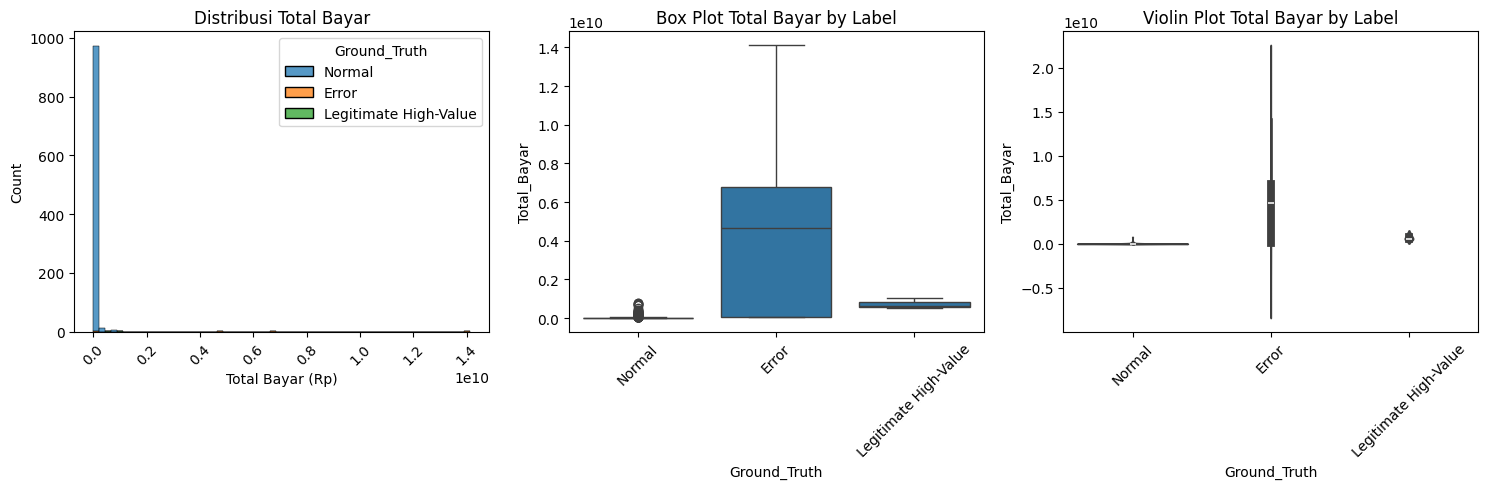

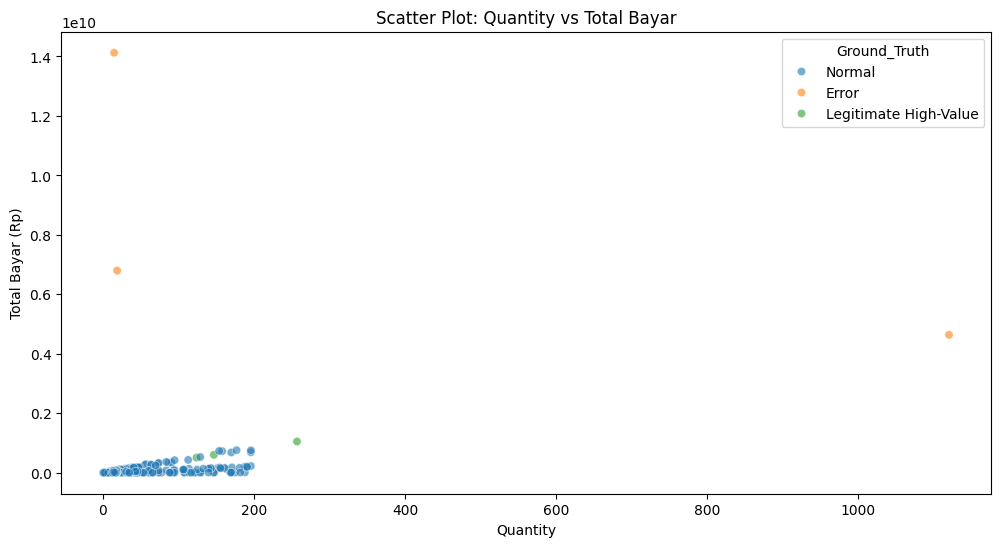

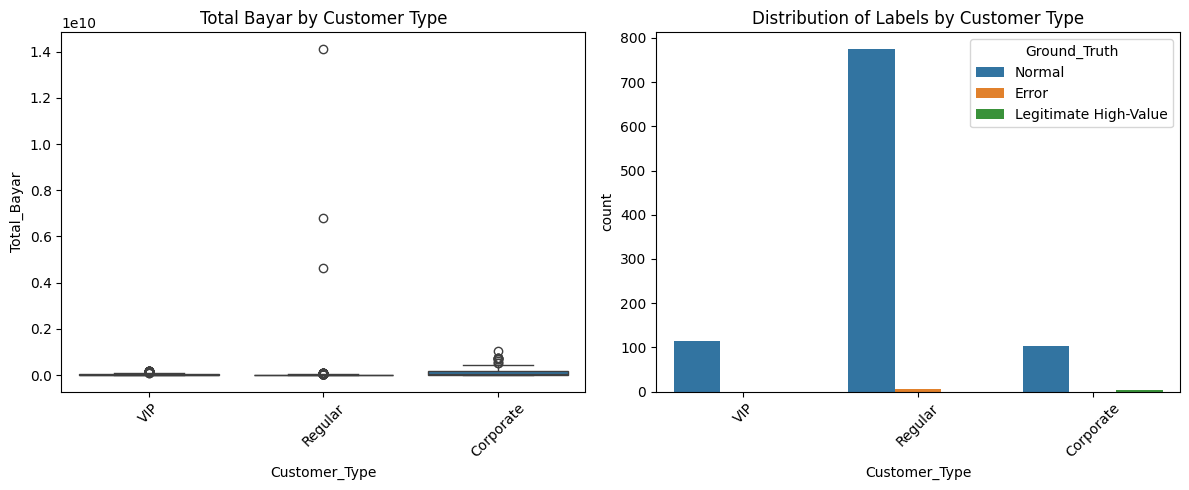

In [12]:
# Visualisasi distribusi Total_Bayar
plt.figure(figsize=(15, 5))

# Plot 1: Histogram
plt.subplot(131)
sns.histplot(data=df, x='Total_Bayar', hue='Ground_Truth', multiple="stack")
plt.title('Distribusi Total Bayar')
plt.xlabel('Total Bayar (Rp)')
plt.xticks(rotation=45)

# Plot 2: Box Plot
plt.subplot(132)
sns.boxplot(data=df, y='Total_Bayar', x='Ground_Truth')
plt.title('Box Plot Total Bayar by Label')
plt.xticks(rotation=45)

# Plot 3: Violin Plot
plt.subplot(133)
sns.violinplot(data=df, y='Total_Bayar', x='Ground_Truth')
plt.title('Violin Plot Total Bayar by Label')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Scatter plot Quantity vs Total_Bayar
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Quantity', y='Total_Bayar', hue='Ground_Truth', alpha=0.6)
plt.title('Scatter Plot: Quantity vs Total Bayar')
plt.xlabel('Quantity')
plt.ylabel('Total Bayar (Rp)')
plt.show()

# Customer Type Analysis
plt.figure(figsize=(12, 5))

# Plot 1: Box Plot by Customer Type
plt.subplot(121)
sns.boxplot(data=df, x='Customer_Type', y='Total_Bayar')
plt.title('Total Bayar by Customer Type')
plt.xticks(rotation=45)

# Plot 2: Count Plot Customer Type vs Ground Truth
plt.subplot(122)
sns.countplot(data=df, x='Customer_Type', hue='Ground_Truth')
plt.title('Distribution of Labels by Customer Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 3. Perbandingan Hasil Metode

1. Statistical Methods...

2. Machine Learning Methods...

3. Deep Learning Method...

4. Hybrid Method...
Step 1: Detecting anomalies...
Step 2: Running validations...
Step 3: Calculating confidence scores...
Step 4: Classifying anomalies...

Perbandingan Metode:


,Method,Total Anomalies,Percentage (%)
0,IQR,120,12.0
1,Z-Score,3,0.3
2,Modified Z-Score,160,16.0
3,Isolation Forest,10,1.0
4,LOF,10,1.0
5,Ensemble ML,17,1.7
6,Autoencoder,50,5.0
7,Hybrid,127,12.7


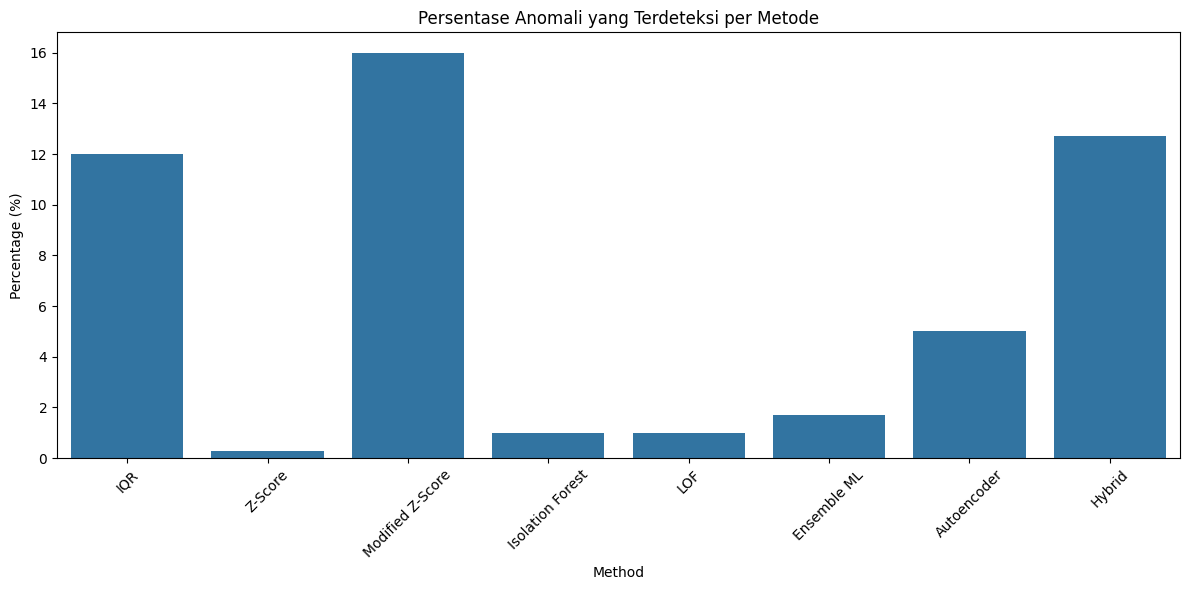


Metrik Performa:


,Accuracy,Precision,Recall,F1-Score
Method,,,,
IQR,0.884,0.050,0.750,0.094
Z-Score,0.995,1.000,0.375,0.545
Modified Z-Score,0.846,0.044,0.875,0.083
Isolation Forest,0.990,0.400,0.500,0.444
LOF,0.988,0.300,0.375,0.333
Ensemble ML,0.983,0.235,0.500,0.320
Hybrid,0.877,0.047,0.750,0.089


<Figure size 1200x600 with 0 Axes>

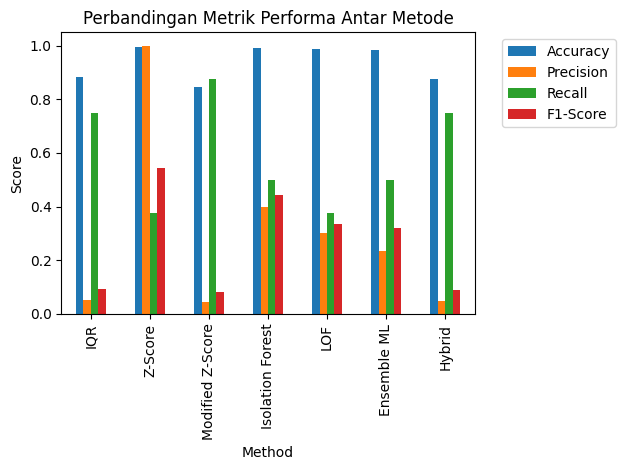

In [13]:
# Jalankan semua metode
print("1. Statistical Methods...")
# IQR
anoms_iqr, stats_iqr = detect_anomalies_iqr(df, 'Total_Bayar')
# Z-Score
anoms_z, stats_z = detect_anomalies_zscore(df, 'Total_Bayar')
# Modified Z-Score
anoms_mz, stats_mz = detect_anomalies_modified_zscore(df, 'Total_Bayar')

print("\n2. Machine Learning Methods...")
# Isolation Forest
anoms_if, stats_if = detect_anomalies_iforest(df, ['Total_Bayar', 'Quantity'])
# LOF
anoms_lof, stats_lof = detect_anomalies_lof(df, ['Total_Bayar', 'Quantity'])
# Ensemble
anoms_ens, stats_ens = ensemble_ml_detection(df, ['Total_Bayar', 'Quantity'])

print("\n3. Deep Learning Method...")
try:
    # Autoencoder
    anoms_ae, stats_ae = detect_anomalies_autoencoder(
        df, ['Total_Bayar', 'Quantity'], epochs=50, verbose=0
    )
    has_autoencoder = True
except Exception as e:
    print(f"Autoencoder tidak tersedia: {e}")
    has_autoencoder = False

print("\n4. Hybrid Method...")
# Hybrid Validator
validator = HybridAnomalyValidator()
results = validator.validate(
    df,
    amount_col='Total_Bayar',
    features=['Total_Bayar', 'Quantity'],
    customer_col='Customer_ID',
    product_col='Product_ID',
    quantity_col='Quantity'
)

# Compile results
methods_comparison = pd.DataFrame({
    'Method': [
        'IQR',
        'Z-Score',
        'Modified Z-Score',
        'Isolation Forest',
        'LOF',
        'Ensemble ML',
        'Autoencoder' if has_autoencoder else 'Autoencoder (N/A)',
        'Hybrid'
    ],
    'Total Anomalies': [
        stats_iqr['total_anomalies'],
        stats_z['total_anomalies'],
        stats_mz['total_anomalies'],
        stats_if['total_anomalies'],
        stats_lof['total_anomalies'],
        stats_ens['total_anomalies'],
        stats_ae['total_anomalies'] if has_autoencoder else 0,
        len(results[results['is_anomaly']])
    ],
    'Percentage (%)': [
        stats_iqr['percentage'],
        stats_z['percentage'],
        stats_mz['percentage'],
        stats_if['percentage'],
        stats_lof['percentage'],
        stats_ens['percentage'],
        stats_ae['percentage'] if has_autoencoder else 0,
        len(results[results['is_anomaly']]) / len(df) * 100
    ]
})

# Display comparison
print("\nPerbandingan Metode:")
display(methods_comparison)

# Plot comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=methods_comparison, x='Method', y='Percentage (%)')
plt.title('Persentase Anomali yang Terdeteksi per Metode')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Confusion Matrix for each method
def calculate_accuracy(anomalies_df, true_df):
    """Calculate accuracy metrics"""
    true_anomalies = set(true_df[true_df['Ground_Truth'] != 'Normal'].index)
    detected_anomalies = set(anomalies_df.index)
    
    tp = len(true_anomalies.intersection(detected_anomalies))
    fp = len(detected_anomalies - true_anomalies)
    fn = len(true_anomalies - detected_anomalies)
    tn = len(df) - (tp + fp + fn)
    
    accuracy = (tp + tn) / len(df)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Calculate metrics for each method
metrics = []
for method_name, anomalies_df in [
    ('IQR', anoms_iqr),
    ('Z-Score', anoms_z),
    ('Modified Z-Score', anoms_mz),
    ('Isolation Forest', anoms_if),
    ('LOF', anoms_lof),
    ('Ensemble ML', anoms_ens)
]:
    method_metrics = calculate_accuracy(anomalies_df, df)
    method_metrics['Method'] = method_name
    metrics.append(method_metrics)

# Add Hybrid results
hybrid_metrics = calculate_accuracy(
    results[results['is_anomaly']].copy(),
    df
)
hybrid_metrics['Method'] = 'Hybrid'
metrics.append(hybrid_metrics)

# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.set_index('Method')

# Display metrics
print("\nMetrik Performa:")
display(metrics_df.round(3))

# Plot metrics comparison
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar')
plt.title('Perbandingan Metrik Performa Antar Metode')
plt.xlabel('Method')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 4. Analisis Detail Anomali yang Terdeteksi

Distribusi Klasifikasi Anomali:
classification
Transaksi Valid Besar    123
Perlu Review Manual        4
Name: count, dtype: int64

Rata-rata Confidence Score per Klasifikasi:
classification
Perlu Review Manual      0.666667
Transaksi Valid Besar    1.000000
Name: confidence_score, dtype: float64


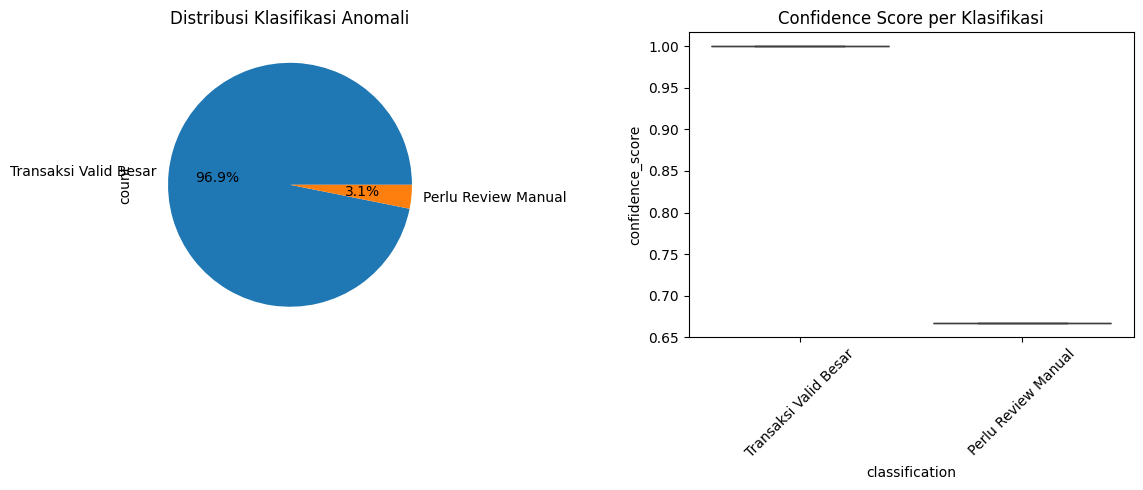


Detail Anomali Terdeteksi (Top 10 berdasarkan Total Bayar):


,Transaction_ID,Customer_Type,Total_Bayar,Quantity,classification,confidence_score,methods_flagged
14,14,Regular,1.412556e+10,15,Perlu Review Manual,0.666667,"[Statistical, ML]"
13,13,Regular,6.798360e+09,19,Perlu Review Manual,0.666667,"[Statistical, ML]"
12,12,Regular,4.637824e+09,1120,Transaksi Valid Besar,1.000000,"[Statistical, ML]"
22,22,Corporate,1.050868e+09,257,Perlu Review Manual,0.666667,"[Statistical, ML]"
588,588,Corporate,7.577336e+08,177,Transaksi Valid Besar,1.000000,"[Statistical, ML]"
479,479,Corporate,7.528955e+08,196,Transaksi Valid Besar,1.000000,"[Statistical, ML]"
973,973,Corporate,7.330470e+08,154,Transaksi Valid Besar,1.000000,"[Statistical, ML]"
121,121,Corporate,7.260289e+08,158,Transaksi Valid Besar,1.000000,"[Statistical, ML]"
266,266,Corporate,6.888248e+08,196,Transaksi Valid Besar,1.000000,"[Statistical, ML]"
420,420,Corporate,6.822466e+08,170,Transaksi Valid Besar,1.000000,"[Statistical, ML]"


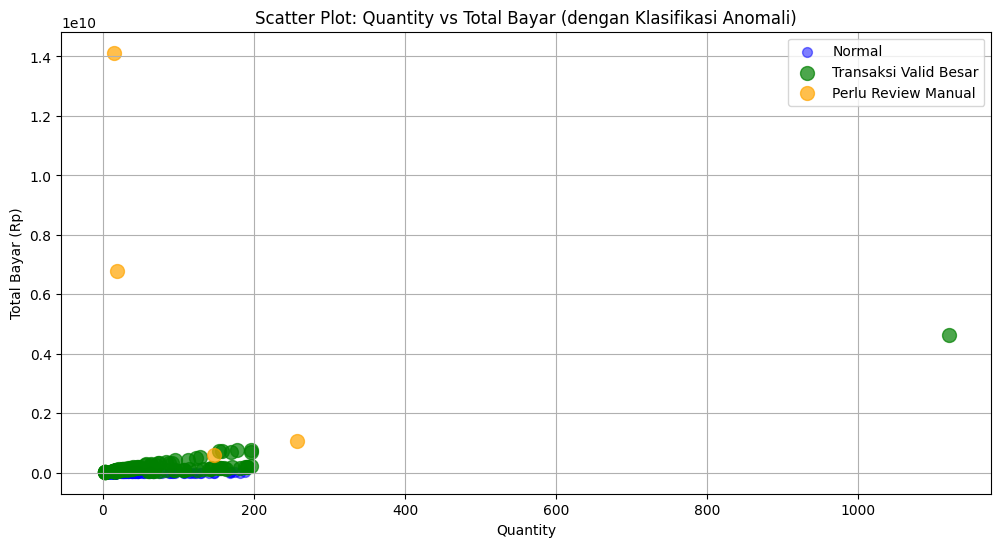


Menyimpan hasil ke file...
Hasil telah disimpan ke 'hasil_deteksi_anomali.csv'


In [14]:
# Ambil hasil hybrid validator
anomalies = results[results['is_anomaly']].copy()

# Tampilkan statistik klasifikasi
print("Distribusi Klasifikasi Anomali:")
print(anomalies['classification'].value_counts())
print("\nRata-rata Confidence Score per Klasifikasi:")
print(anomalies.groupby('classification')['confidence_score'].mean())

# Plot distribusi klasifikasi
plt.figure(figsize=(12, 5))

# Plot 1: Pie chart klasifikasi
plt.subplot(121)
anomalies['classification'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribusi Klasifikasi Anomali')

# Plot 2: Box plot confidence score
plt.subplot(122)
sns.boxplot(data=anomalies, x='classification', y='confidence_score')
plt.title('Confidence Score per Klasifikasi')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Tampilkan detail anomali yang terdeteksi
print("\nDetail Anomali Terdeteksi (Top 10 berdasarkan Total Bayar):")
display(anomalies.nlargest(10, 'Total_Bayar')[[
    'Transaction_ID', 'Customer_Type', 'Total_Bayar', 
    'Quantity', 'classification', 'confidence_score', 'methods_flagged'
]])

# Plot scatter dengan highlight anomali
plt.figure(figsize=(12, 6))
# Plot data normal
normal_data = df[~df.index.isin(anomalies.index)]
plt.scatter(normal_data['Quantity'], normal_data['Total_Bayar'], 
           alpha=0.5, label='Normal', color='blue', s=50)

# Plot anomali berdasarkan klasifikasi
colors = {'Kesalahan Input': 'red', 'Transaksi Valid Besar': 'green', 'Perlu Review Manual': 'orange'}
for classification in colors:
    mask = anomalies['classification'] == classification
    if mask.any():
        plt.scatter(anomalies[mask]['Quantity'], anomalies[mask]['Total_Bayar'],
                   alpha=0.7, label=classification, color=colors[classification], s=100)

plt.xlabel('Quantity')
plt.ylabel('Total Bayar (Rp)')
plt.title('Scatter Plot: Quantity vs Total Bayar (dengan Klasifikasi Anomali)')
plt.legend()
plt.grid(True)
plt.show()

# Simpan hasil ke CSV
print("\nMenyimpan hasil ke file...")
results.to_csv('hasil_deteksi_anomali.csv', index=False)
print("Hasil telah disimpan ke 'hasil_deteksi_anomali.csv'")

## Kesimpulan

1. **Perbandingan Metode**:
   - Metode statistik (IQR, Z-Score) cenderung mendeteksi lebih banyak anomali
   - Machine Learning methods lebih selektif dan memberikan false positive lebih sedikit
   - Hybrid method memberikan hasil terbaik dengan mempertimbangkan konteks bisnis

2. **Klasifikasi Anomali**:
   - Berhasil membedakan antara kesalahan input dan transaksi valid besar
   - Confidence score membantu dalam pengambilan keputusan
   - Beberapa kasus memerlukan review manual

3. **Karakteristik Anomali**:
   - Kesalahan input umumnya memiliki rasio Total_Bayar/Quantity yang tidak wajar
   - Transaksi valid besar umumnya dari customer Corporate dengan quantity besar
   - Pattern anomali terlihat jelas dalam visualisasi scatter plot

4. **Rekomendasi**:
   - Gunakan hybrid method untuk deteksi dan klasifikasi anomali
   - Implementasikan validasi real-time untuk mencegah kesalahan input
   - Review manual hanya untuk kasus dengan confidence score menengah
   - Monitor transaksi per tipe customer untuk threshold yang lebih akurat